In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Symbolic limit

In [468]:
a, b, g = sp.symbols('alpha beta gamma')

num1 = 1 + b * (1-a)**2 * (1-g)
den1 = sp.exp(b) - 1

expr1 = num1 / den1
expr2 = 5*a + (1-a)**2 * g + 2*a**2/(1-2*a) - 2*a**2
expr3 = expr1 + expr2

num2 = a * (1-2*a) * (1-sp.exp(-b))
den2 = 1 - 2 * sp.exp(-b) * a - 3 * (1-sp.exp(-b)) * a**2
expr4 = num2 / den2

full = expr3 * expr4
full

alpha*(1 - 2*alpha)*(1 - exp(-beta))*(-2*alpha**2 + 2*alpha**2/(1 - 2*alpha) + 5*alpha + gamma*(1 - alpha)**2 + (beta*(1 - alpha)**2*(1 - gamma) + 1)/(exp(beta) - 1))/(-alpha**2*(3 - 3*exp(-beta)) - 2*alpha*exp(-beta) + 1)

In [469]:
limit = sp.limit(full, b, sp.oo)
limit

(2*alpha**4*gamma - 4*alpha**4 - 5*alpha**3*gamma + 10*alpha**3 + 4*alpha**2*gamma - 5*alpha**2 - alpha*gamma)/(3*alpha**2 - 1)

In [470]:
limitLambdify = sp.lambdify((a, g), limit)
limitLambdify(0.25, 0.0), limit.evalf(subs={a:0.25, g:0.0})

(0.21153846153846154, 0.211538461538462)

In [5]:
def REWARD(a, g):
    num = 5*(a**2) - 12*(a**3) + 9*(a**4) - 2*(a**5) + g * (a - 4*(a**2) + 6*(a**3) - 5*(a**4) + 2*(a**5))
    den = 2*(a**3) - 4*(a**2) + 1
    return num / den

In [6]:
def REWARD2(alpha, beta, gamma):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [31]:
REWARD2(0.25, 100, 0.0),limitLambdify(0.25, 0.0)

(0.21153846153846156, 0.21153846153846154)

In [33]:
alphas = np.arange(0.01, 0.5, 0.001)
gamma  = 0.

REWARD_THEO   = np.array([REWARD(a,gamma) for a in alphas])
REWARD2_THEO  = np.array([REWARD2(a,100,gamma) for a in alphas])
REWARD2_THEO2 = np.array([limitLambdify(a,gamma) for a in alphas])

In [37]:
np.abs(REWARD2_THEO-REWARD2_THEO2).max()

7.771561172376096e-16

In [44]:
def simSelfishNoGamma(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                nextExecRews  = np.random.exponential()
                curTime      += nextExecRews
                if nextAttBlock:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [45]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simResNoG = []
for a in tqdm(simAlphas):
    temp = []
    for j in range(10):
        temp.append(simSelfishNoGamma(a))
    simResNoG.append(np.mean(temp))

100%|██████████| 19/19 [01:52<00:00,  5.92s/it]


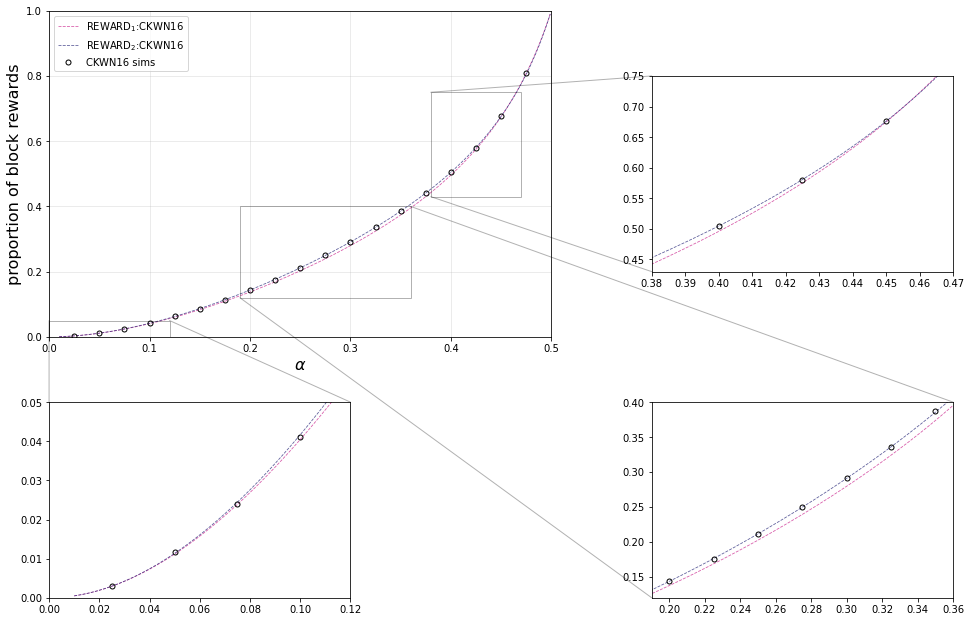

In [49]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0., 0.12), ylim=(0., .05))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.38, 0.47), ylim=(0.43, 0.75))
axins2 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.19, 0.36), ylim=(0.12, 0.4))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

for a in [ax, axins0, axins1, axins2]:
    a.plot(alphas, REWARD_THEO, label=r'REWARD$_1$:CKWN16', linestyle='--', color='mediumvioletred',
           alpha=0.7, linewidth=0.8)
    a.plot(alphas, REWARD2_THEO, label=r'REWARD$_2$:CKWN16', linestyle='--', color='midnightblue',
           alpha=0.7, linewidth=0.8)
    a.plot(simAlphas, simResNoG, linestyle='none', color='black', marker='o', fillstyle='none',
           markersize=5, label='CKWN16 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

# Sims with gamma

In [486]:
def EyalSirer(a, g):
    num = a * ((1-a)**2) * (4*a + g*(1-2*a)) - a**3
    den = 1 - a * (1 + (2-a) * a)
    return num / den

In [487]:
EyalSirer(0.25,1/2), EyalSirer(0.3,0.25), EyalSirer(1/3,0)

(0.25, 0.29999999999999993, 0.33333333333333337)

In [488]:
alphas = np.arange(0.01, 0.5, 0.001)
gammas = [0, 0.5, 1]

ES_THEO       = []
REWARD2_THEO  = []
REWARD2_THEO2 = []
for g in gammas:
    ES_THEO.append([EyalSirer(a, g) for a in alphas])
    REWARD2_THEO.append([REWARD2(a, 100, g) for a in alphas])
    REWARD2_THEO2.append([limitLambdify(a, g) for a in alphas])
ES_THEO    = np.array(ES_THEO)
REWARD2_THEO = np.array(REWARD2_THEO)
REWARD2_THEO2 = np.array(REWARD2_THEO2)
ES_THEO.shape, REWARD2_THEO.shape, REWARD2_THEO2.shape

((3, 490), (3, 490), (3, 490))

In [489]:
np.abs(REWARD2_THEO-REWARD2_THEO2).max()

1.1102230246251565e-15

In [490]:
def simES(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                sample = np.random.uniform()
                if sample < alpha:
                    attackBlcs += 2
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                else: 
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [491]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_SIM = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simES(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    ES_SIM.append(temp)
ES_SIM = np.array(ES_SIM)
ES_SIM.shape

(3, 19)

In [492]:
def simCKWN(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [493]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_SIM = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simCKWN(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    CKWN_SIM.append(temp)
CKWN_SIM = np.array(CKWN_SIM)
CKWN_SIM.shape

(3, 19)

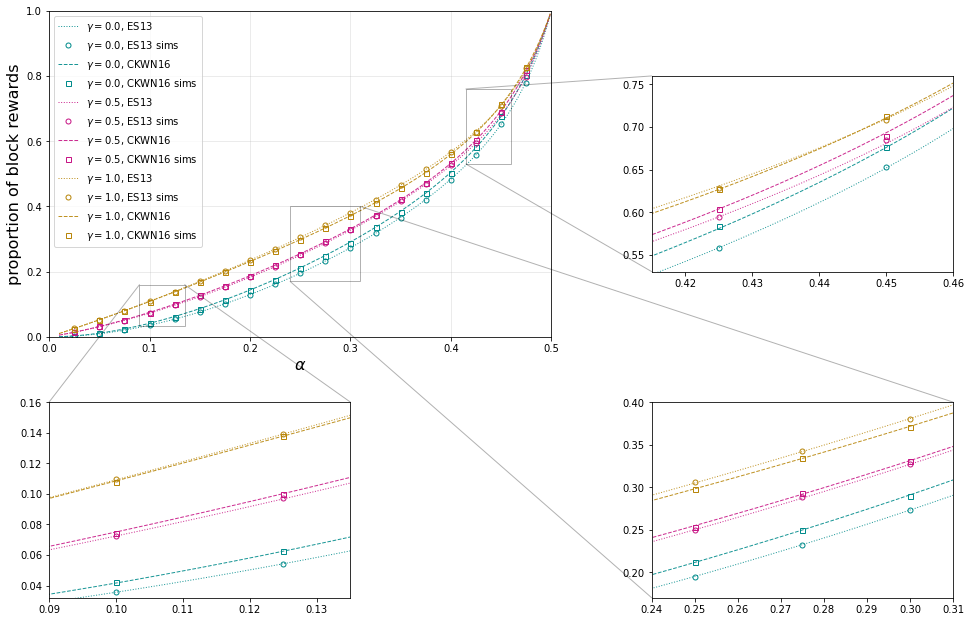

In [494]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0.09, 0.135), ylim=(0.032, .16))
axins1 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.24, 0.31), ylim=(0.17, 0.4))
axins2 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.415, 0.46), ylim=(0.53, 0.76))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

colors = ['darkcyan', 'mediumvioletred', 'darkgoldenrod'] 
for a in [ax, axins0, axins1, axins2]:
    for i, g in enumerate(gammas):
        a.plot(alphas, ES_THEO[i], label=r'$\gamma=${:0.1f}, ES13'.format(g), 
               linestyle='dotted', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, ES_SIM[i], linestyle='none', color=colors[i], marker='o', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, ES13 sims'.format(g))

        a.plot(alphas, REWARD2_THEO[i], label=r'$\gamma=${:0.1f}, CKWN16'.format(g),
               linestyle='--', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, CKWN_SIM[i], linestyle='none', color=colors[i], marker='s', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, CKWN16 sims'.format(g))

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

# other gammas both rews

In [464]:
def REWARD(a, g):
    num = 5*(a**2) - 12*(a**3) + 9*(a**4) - 2*(a**5) + g * (a - 4*(a**2) + 6*(a**3) - 5*(a**4) + 2*(a**5))
    den = 2*(a**3) - 4*(a**2) + 1
    return num / den

In [465]:
def REWARD2(alpha, beta, gamma):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [31]:
REWARD2(0.25, 100, 0.0),limitLambdify(0.25, 0.0)

(0.21153846153846156, 0.21153846153846154)

In [471]:
alphas = np.arange(0.01, 0.5, 0.001)
gammas  = [0., 1/2., 1.]

REWARD_THEO  = []
REWARD2_THEO = []
for _g in gammas:
    REWARD_THEO.append([REWARD(a,_g) for a in alphas])
    REWARD2_THEO.append([limitLambdify(a,_g) for a in alphas])
REWARD_THEO = np.asarray(REWARD_THEO)
REWARD2_THEO = np.asarray(REWARD2_THEO)
REWARD_THEO.shape

(3, 490)

In [45]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simResNoG = []
for a in tqdm(simAlphas):
    temp = []
    for j in range(10):
        temp.append(simSelfishNoGamma(a))
    simResNoG.append(np.mean(temp))

100%|██████████| 19/19 [01:52<00:00,  5.92s/it]


In [475]:
def simCKWN(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [476]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_SIM = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simCKWN(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    CKWN_SIM.append(temp)
CKWN_SIM = np.array(CKWN_SIM)
CKWN_SIM.shape

(3, 19)

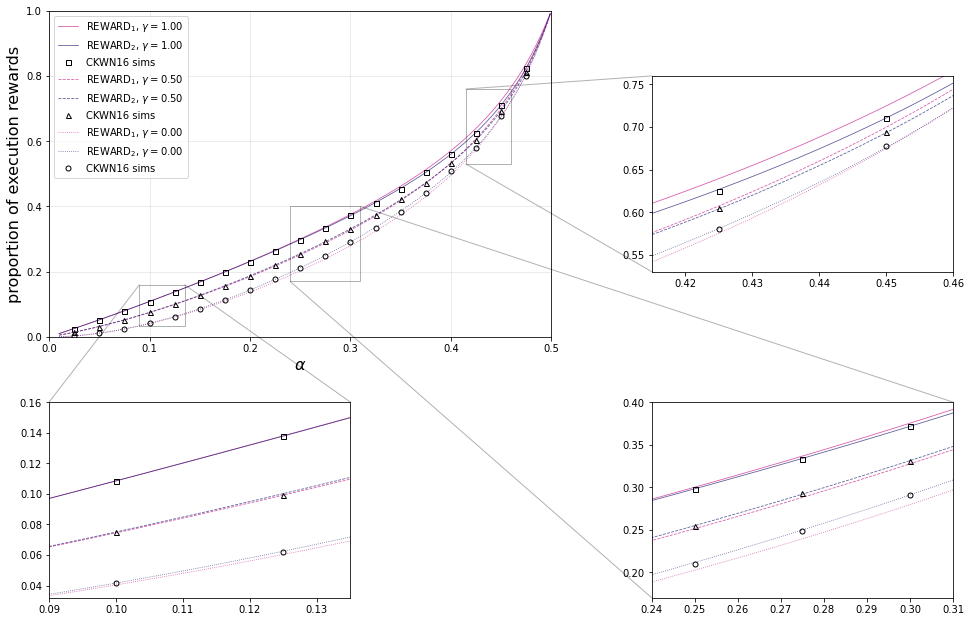

In [482]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0.09, 0.135), ylim=(0.032, .16))
axins1 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.24, 0.31), ylim=(0.17, 0.4))
axins2 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.415, 0.46), ylim=(0.53, 0.76))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

linestyles = ['dotted', 'dashed', '-']
markers    = ['o', '^', 's']
for a in [ax, axins0, axins1, axins2]:
    for i in [2,1,0]:
        a.plot(alphas, REWARD_THEO[i], label=r'REWARD$_1$, $\gamma=${:0.2f}'.format(gammas[i]), 
               linestyle=linestyles[i], color='mediumvioletred', alpha=0.7, linewidth=0.8)
        a.plot(alphas, REWARD2_THEO[i], label=r'REWARD$_2$, $\gamma=${:0.2f}'.format(gammas[i]), 
               linestyle=linestyles[i], color='midnightblue', alpha=0.7, linewidth=0.8)
        a.plot(simAlphas, CKWN_SIM[i], linestyle='none', color='black', marker=markers[i], fillstyle='none',
               markersize=5, label='CKWN16 sims')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of execution rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=100, bbox_inches='tight', facecolor='white')

plt.show()

# Optimal beta sims

In [86]:
def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

def calcTotalRewardGamma(a, b, gamma, scale=1):
    return (scale*REWARD2(alpha=a, beta=b, gamma=gamma) + calcAOverAHGamma(a=a, b=b, gamma=gamma)) / (scale + 1)

In [88]:
# CKWN optimal betas (exec rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 5.01, 0.01)
opt_betas_exec = []
for alpha in tqdm(alphas):
    rews = [REWARD2(alpha=alpha, beta=b, gamma=0.) for b in betas]
    opt_betas_exec.append(betas[np.argmax(rews)])
opt_betas_exec = np.asarray(opt_betas_exec)

100%|██████████| 490/490 [00:06<00:00, 77.40it/s]


In [89]:
# our optimal betas (exec & block rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 10.01, 0.01)
opt_betas_both = []
for alpha in tqdm(alphas):
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=0., scale=1.) for b in betas]
    opt_betas_both.append(betas[np.argmax(rews)])
opt_betas_both = np.asarray(opt_betas_both)

100%|██████████| 490/490 [00:27<00:00, 17.60it/s]


In [105]:
CKWN_theo_opt_beta = []
OURS_theo_opt_beta = []
ES_tho_beta_infty  = []
for i in tqdm(range(len(alphas))):
    a, optb_exec, optb_both = alphas[i], opt_betas_exec[i], opt_betas_both[i]
    CKWN_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_exec, gamma=0., scale=1.))
    OURS_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_both, gamma=0., scale=1.))
    ES_tho_beta_infty.append(calcTotalRewardGamma(a=a, b=100., gamma=0., scale=1.))
CKWN_theo_opt_beta = np.array(CKWN_theo_opt_beta)
OURS_theo_opt_beta = np.array(OURS_theo_opt_beta)
ES_tho_beta_infty  = np.array(ES_tho_beta_infty)
CKWN_theo_opt_beta.shape, OURS_theo_opt_beta.shape, ES_tho_beta_infty.shape 

100%|██████████| 490/490 [00:00<00:00, 5140.14it/s]


((490,), (490,), (490,))

In [94]:
def simCKWN_beta_lambda(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

In [95]:
def findOptBetaExec(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [REWARD2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
    return betas[np.argmax(rews)]

def findOptBetaBoth(alpha, gamma, scale=1):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas]
    return betas[np.argmax(rews)]

In [97]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaExec(a, 0.)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    CKWN_sim_lambda.append(np.mean(temp))
CKWN_sim_lambda = np.array(CKWN_sim_lambda)
CKWN_sim_lambda.shape

(19,)

In [99]:
simAlphas = np.arange(0.025, 0.5, 0.025)
OURS_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaBoth(a, 0.)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    OURS_sim_lambda.append(np.mean(temp))
OURS_sim_lambda = np.array(OURS_sim_lambda)
OURS_sim_lambda.shape

(19,)

In [101]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim_lambda = []
for a in simAlphas:
    optb = 100.
    print('alpha={:0.3f}'.format(a), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1., n=int(1e5)))
    ES_sim_lambda.append(np.mean(temp))
ES_sim_lambda = np.array(ES_sim_lambda)
ES_sim_lambda.shape

(19,)

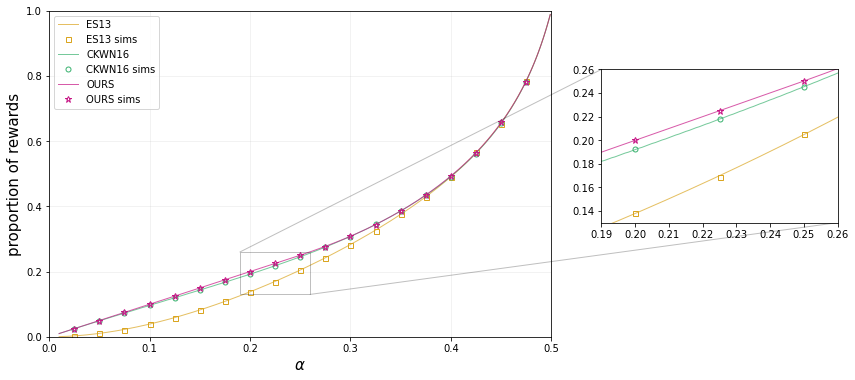

In [484]:
f, ax = plt.subplots(figsize=(9,6))

axins = ax.inset_axes(
    [1.1, 0.35, 0.47, 0.47],
    xlim=(.19, .26), ylim=(.13, .26))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for a in [ax, axins]:
    a.plot(alphas, ES_tho_beta_infty, linewidth=1, color='goldenrod', alpha=0.7, label='ES13', 
            linestyle='-')
    a.plot(simAlphas, ES_sim_lambda, color='goldenrod', alpha=1, label='ES13 sims', marker='s', 
           fillstyle='none', linestyle='none', markersize=5)
        
    a.plot(alphas, CKWN_theo_opt_beta, linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16', 
            linestyle='-')
    a.plot(simAlphas, CKWN_sim_lambda, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)

    a.plot(alphas, OURS_theo_opt_beta, linewidth=1, color='mediumvioletred', alpha=0.7, label='OURS', 
            linestyle='-')
    a.plot(simAlphas, OURS_sim_lambda, color='mediumvioletred', alpha=1, label='OURS sims', marker='*', 
           fillstyle='none', linestyle='none', markersize=7)
    
    
#     a.plot(alphas,alphas, color='k', alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)

plt.savefig('out.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

# 3d plot for best beta-cutoff

In [108]:
# first, theoretical
alpha  = 0.3
betas  = np.arange(0.01, 10.01, 0.01)
gammas = np.arange(0, 1.01, 0.01)
scales = [1/10, 1, 10]
bCutoffRews = []
selfishRews = []
for scale in tqdm(scales):
    temp, temp2 = [], []
    for g in gammas:
        temp.append(np.array([calcTotalRewardGamma(a=alpha, b=b, gamma=g, scale=scale) for b in betas]))
        temp2.append(np.array([calcTotalRewardGamma(a=alpha, b=30, gamma=g, scale=scale)]*len(betas)))
    bCutoffRews.append(temp)
    selfishRews.append(temp2)
bCutoffRews = np.array(bCutoffRews)
selfishRews = np.array(selfishRews)
bCutoffRews.shape, selfishRews.shape

100%|██████████| 3/3 [00:12<00:00,  4.23s/it]


((3, 101, 1000), (3, 101, 1000))

In [114]:
betas, gammas = np.meshgrid(betas, gammas)
betas.shape, gammas.shape

((101, 1000), (101, 1000))

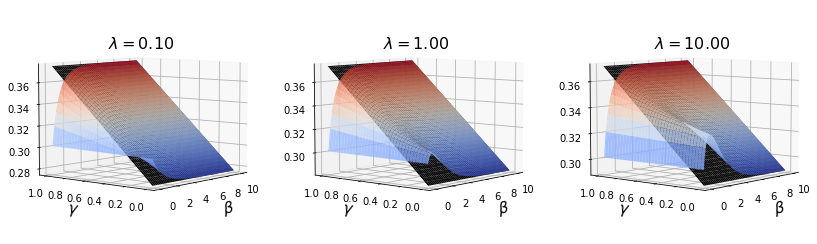

In [116]:
f, axarr = plt.subplots(ncols=3, figsize=(14,7), subplot_kw={"projection": "3d"})

for i in range(3):
    axarr[i].plot_surface(betas, gammas, selfishRews[i], color='k', alpha=1)
    axarr[i].plot_surface(betas, gammas, bCutoffRews[i], cmap=mpl.cm.coolwarm, alpha=0.8)

    axarr[i].view_init(elev=6, azim=220)
    axarr[i].text2D(0.5, 0.82, r'$\lambda=${:0.2f}'.format(scales[i]), 
                    transform=axarr[i].transAxes, ha='center', size=16)
    
    
for i, ax in enumerate(axarr):
    ax.set_xlabel(r'$\beta$', size=15)
    ax.set_ylabel(r'$\gamma$', size=15)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# other reward distributions 

- SQRT Time
- SQRT+linear Time with ratio
- High one-off blocks

In [120]:
def simGeneral_beta_lambda(alpha, gamma, beta, rewards, scale=1., n=int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        time     = np.random.exponential()
        execRews = rewards(time)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

# SQRT time 

- alpha  = 0.3
- gamma  = 0, 1/2, 1
- lambda = 1

various betas

In [184]:
simBetas = np.arange(0.0, 3, 0.12)
gammas   = [0, 1/4, 1/2]
scale    = 1.0
simBetas

array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ,
       1.32, 1.44, 1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52,
       2.64, 2.76, 2.88])

In [185]:
def sqrtRewards(time):
    return np.sqrt(time)

In [187]:
# SQRT time 
simSQRT      = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=0.3, gamma=g, beta=b, rewards=sqrtRewards, n=int(2e4))
            temp.append(res)
        tempOut.append(np.mean(temp))
    simSQRT.append(tempOut)
simSQRT = np.array(simSQRT)
simSQRT.shape

100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


(3, 25)

In [165]:
selfishSQRT = [
    simGeneral_beta_lambda(alpha=0.3, gamma=0.00, beta=100, rewards=sqrtRewards, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.25, beta=100, rewards=sqrtRewards, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.50, beta=100, rewards=sqrtRewards, n=int(10e5))
]
selfishSQRT

[0.2841504889272969, 0.30576021333260583, 0.32822754454042113]

In [144]:
def sqrtPlusLinearRewards(time):
    return time + np.sqrt(time)

In [189]:
# SQRT+linear time 
simSQRT_LIN      = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=0.3, gamma=g, beta=b, 
                                         rewards=sqrtPlusLinearRewards, n=int(2e4))
            temp.append(res)
        tempOut.append(np.mean(temp))
    simSQRT_LIN.append(tempOut)
simSQRT_LIN = np.array(simSQRT_LIN)
simSQRT_LIN.shape

100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


(3, 25)

In [190]:
selfishSQRT_LIN = [
    simGeneral_beta_lambda(alpha=0.3, gamma=0.00, beta=100, rewards=sqrtPlusLinearRewards, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.25, beta=100, rewards=sqrtPlusLinearRewards, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.50, beta=100, rewards=sqrtPlusLinearRewards, n=int(10e5))
]
selfishSQRT_LIN

[0.2826872021937439, 0.3062877582692213, 0.3290106625426753]

In [302]:
def linearPlusConst(time):
    return time + np.random.binomial(n=1, p=0.25)*4

In [303]:
# linear+const time 
simLIN_CONST = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=0.3, gamma=g, beta=b, 
                                         rewards=linearPlusConst, n=int(2e4))
            temp.append(res)
        tempOut.append(np.mean(temp))
    simLIN_CONST.append(tempOut)
simLIN_CONST = np.array(simLIN_CONST)
simLIN_CONST.shape

100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


(3, 25)

In [304]:
selfishLIN_CONST = [
    simGeneral_beta_lambda(alpha=0.3, gamma=0.00, beta=100, rewards=linearPlusConst, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.25, beta=100, rewards=linearPlusConst, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.50, beta=100, rewards=linearPlusConst, n=int(10e5))
]
selfishLIN_CONST

[0.281608191514103, 0.3048966369715128, 0.33025170151079863]

In [320]:
def randomDouble(time):
    return np.random.binomial(n=1, p=0.5)

In [322]:
# no time dependence, random double 
simDOUBLE = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=0.3, gamma=g, beta=b, 
                                         rewards=randomDouble, n=int(2e4))
            temp.append(res)
        tempOut.append(np.mean(temp))
    simDOUBLE.append(tempOut)
simDOUBLE = np.array(simDOUBLE)
simDOUBLE.shape

100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


(3, 25)

In [323]:
selfishDOUBLE = [
    simGeneral_beta_lambda(alpha=0.3, gamma=0.00, beta=100, rewards=randomDouble, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.25, beta=100, rewards=randomDouble, n=int(10e5)),
    simGeneral_beta_lambda(alpha=0.3, gamma=0.50, beta=100, rewards=randomDouble, n=int(10e5))
]
selfishDOUBLE

[0.28344822187256974, 0.30361489316185764, 0.3252707903332912]

In [305]:
betas  = np.arange(0.01, 3.01, 0.01)

In [175]:
# linear time - theoertical
theoLIN  = []
for g in gammas:
    temp = []
    for b in tqdm(betas):
        temp.append(calcTotalRewardGamma(a=alpha, b=b, gamma=g, scale=1.))
    theoLIN.append(temp)
theoLIN = np.array(theoLIN)
theoLIN.shape

100%|██████████| 300/300 [00:00<00:00, 2458.01it/s]


(3, 300)

In [197]:
def rolling_average(data, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

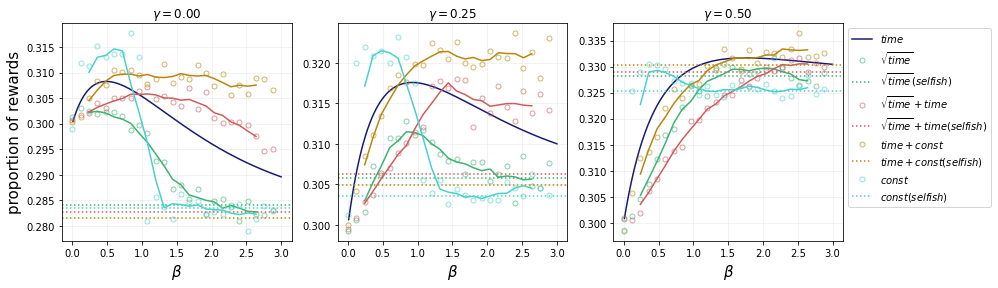

In [376]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

for i in range(3):
    a = axarr[i]
    a.plot(betas, theoLIN[i], color='midnightblue', alpha=1, label=r'$time$', linestyle='-')
    
    
    a.plot(simBetas, simSQRT[i], color='mediumseagreen', alpha=0.6, label=r'$\sqrt{time}$', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)
    a.axhline(selfishSQRT[i], color='mediumseagreen', alpha=1, label=r'$\sqrt{time} (selfish)$',
              linestyle='dotted')
    a.plot(simBetas[2:-2], rolling_average(simSQRT[i], 5), color='mediumseagreen', alpha=1, linestyle='-')
    
    a.plot(simBetas, simSQRT_LIN[i], color='indianred', alpha=0.6, label=r'$\sqrt{time}+time$', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)
    a.axhline(selfishSQRT_LIN[i], color='indianred', alpha=1, label=r'$\sqrt{time}+time (selfish)$',
              linestyle='dotted')
    a.plot(simBetas[2:-2], rolling_average(simSQRT_LIN[i], 5), color='indianred', alpha=1, linestyle='-')
    
    a.plot(simBetas, simLIN_CONST[i], color='darkgoldenrod', alpha=0.6, label=r'$time+const$', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)
    a.axhline(selfishLIN_CONST[i], color='darkgoldenrod', alpha=1, label=r'$time+const (selfish)$',
              linestyle='dotted')
    a.plot(simBetas[2:-2], rolling_average(simLIN_CONST[i], 5), color='darkgoldenrod', alpha=1, linestyle='-')
    
    a.plot(simBetas, simDOUBLE[i], color='mediumturquoise', alpha=0.6, label=r'$const$', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)
    a.axhline(selfishDOUBLE[i], color='mediumturquoise', alpha=1, label=r'$const (selfish)$',
              linestyle='dotted')
    a.plot(simBetas[2:-2], rolling_average(simDOUBLE[i], 5), color='mediumturquoise', alpha=1, linestyle='-')
    
    
    a.set_xlabel(r'$\beta$', size=15)
    a.grid(alpha=0.2)
    a.set_title(r'$\gamma=${:0.2f}'.format(gammas[i]))
    
axarr[0].set_ylabel(r'proportion of rewards', size=15)
axarr[2].legend(bbox_to_anchor=(1,1))
    
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# alpha thresholds

In [ ]:
# 1. choose a gamma
# 2. iterate alphas
# 3. iterate betas
# 4. check if they exceed honest

In [335]:
scale     = 1.0
simGammas = np.arange(0.0, 0.501, 0.1)
simAlphas = np.arange(0.15, 0.5, 0.01)
simBetas  = np.arange(0.0, 3, 0.12)
simGammas, simAlphas, simBetas

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25,
        0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
        0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47,
        0.48, 0.49]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ,
        1.32, 1.44, 1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52,
        2.64, 2.76, 2.88]))

In [352]:
# linear time 
sim_LIN_OPTI = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for b in simBetas:
            temp = []
            for j in range(10):
                res = simCKWN_beta_lambda(alpha=a, gamma=g, beta=b, n=int(1e4))
                temp.append(res)
            tempOut.append(np.mean(temp))
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_LIN_OPTI.append(a)
sim_LIN_OPTI = np.asarray(sim_LIN_OPTI)
sim_LIN_OPTI.shape

gamma:0.00, alpha:0.27
gamma:0.10, alpha:0.25
gamma:0.20, alpha:0.23
gamma:0.30, alpha:0.23
gamma:0.40, alpha:0.19
gamma:0.50, alpha:0.19


(6,)

In [343]:
# linear time 
sim_LIN_SELF = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for j in range(10):
            res = simCKWN_beta_lambda(alpha=a, gamma=g, beta=100, n=int(1e4))
            tempOut.append(res)
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_LIN_SELF.append(a)
sim_LIN_SELF = np.asarray(sim_LIN_SELF)
sim_LIN_SELF.shape

gamma:0.00, alpha:0.33
gamma:0.10, alpha:0.31
gamma:0.20, alpha:0.30
gamma:0.30, alpha:0.27
gamma:0.40, alpha:0.26
gamma:0.50, alpha:0.25


(6,)

In [358]:
# random double opti 
sim_DOUBLE_OPTI = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for b in simBetas:
            temp = []
            for j in range(10):
                res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=b, rewards=randomDouble, n=int(1e4))
                temp.append(res)
            tempOut.append(np.mean(temp))
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_DOUBLE_OPTI.append(a)
sim_DOUBLE_OPTI = np.asarray(sim_DOUBLE_OPTI)
sim_DOUBLE_OPTI.shape

gamma:0.00, alpha:0.26
gamma:0.10, alpha:0.24
gamma:0.20, alpha:0.23
gamma:0.30, alpha:0.21
gamma:0.40, alpha:0.19
gamma:0.50, alpha:0.17


(6,)

In [356]:
# random double selfish
sim_DOUBLE_SELF = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=100, rewards=randomDouble, n=int(1e4))
            tempOut.append(res)
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_DOUBLE_SELF.append(a)
sim_DOUBLE_SELF = np.asarray(sim_DOUBLE_SELF)
sim_DOUBLE_SELF.shape

gamma:0.00, alpha:0.32
gamma:0.10, alpha:0.30
gamma:0.20, alpha:0.30
gamma:0.30, alpha:0.28
gamma:0.40, alpha:0.26
gamma:0.50, alpha:0.24


(6,)

In [366]:
# sqrt 
sim_SQRT_OPTI = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for b in simBetas:
            temp = []
            for j in range(10):
                res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=b, rewards=sqrtRewards, n=int(1e4))
                temp.append(res)
            tempOut.append(np.mean(temp))
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_SQRT_OPTI.append(a)
sim_SQRT_OPTI = np.asarray(sim_SQRT_OPTI)
sim_SQRT_OPTI.shape

gamma:0.00, alpha:0.26
gamma:0.10, alpha:0.27
gamma:0.20, alpha:0.24
gamma:0.30, alpha:0.23
gamma:0.40, alpha:0.20
gamma:0.50, alpha:0.19


(6,)

In [363]:
# sqrt
sim_SQRT_SELF = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=100, rewards=sqrtRewards, n=int(1e4))
            tempOut.append(res)
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_SQRT_SELF.append(a)
sim_SQRT_SELF = np.asarray(sim_SQRT_SELF)
sim_SQRT_SELF.shape

gamma:0.00, alpha:0.32
gamma:0.10, alpha:0.31
gamma:0.20, alpha:0.30
gamma:0.30, alpha:0.28
gamma:0.40, alpha:0.25
gamma:0.50, alpha:0.24


(6,)

In [368]:
# linear + sqrt
sim_LINSQRT_OPTI = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for b in simBetas:
            temp = []
            for j in range(10):
                res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=b, rewards=sqrtPlusLinearRewards, n=int(1e4))
                temp.append(res)
            tempOut.append(np.mean(temp))
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_LINSQRT_OPTI.append(a)
sim_LINSQRT_OPTI = np.asarray(sim_LINSQRT_OPTI)
sim_LINSQRT_OPTI.shape

gamma:0.00, alpha:0.20
gamma:0.10, alpha:0.21
gamma:0.20, alpha:0.18
gamma:0.30, alpha:0.22
gamma:0.40, alpha:0.18
gamma:0.50, alpha:0.17


(6,)

In [364]:
# linear + sqrt
sim_LINSQRT_SELF = []
for g in simGammas:
    for a in simAlphas:
        tempOut = []
        print("gamma:{:0.2f}, alpha:{:0.2f}".format(g, a), end='\r')
        for j in range(10):
            res = simGeneral_beta_lambda(alpha=a, gamma=g, beta=100, rewards=sqrtPlusLinearRewards, n=int(1e4))
            tempOut.append(res)
        tempOut = np.sort(tempOut)[::-1]
        if tempOut[2] > a:
            print()
            break
    sim_LINSQRT_SELF.append(a)
sim_LINSQRT_SELF = np.asarray(sim_LINSQRT_SELF)
sim_LINSQRT_SELF.shape

gamma:0.00, alpha:0.32
gamma:0.10, alpha:0.31
gamma:0.20, alpha:0.30
gamma:0.30, alpha:0.28
gamma:0.40, alpha:0.26
gamma:0.50, alpha:0.23


(6,)

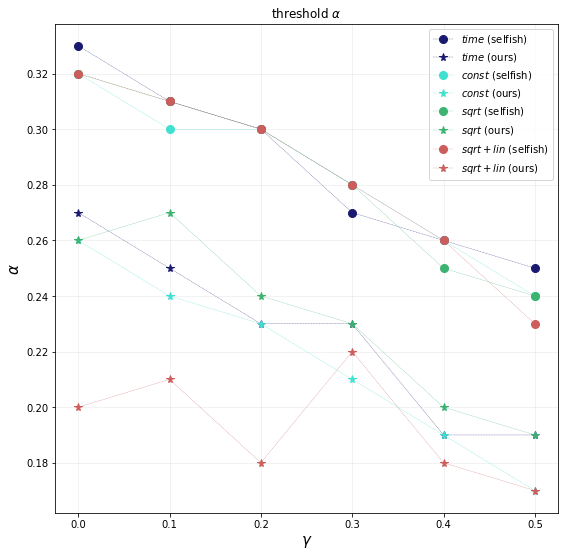

In [374]:
f, ax = plt.subplots(figsize=(9,9))

ax.plot(simGammas, sim_LIN_SELF, color='midnightblue', alpha=1, label=r'$time$ (selfish)', marker='o', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)
ax.plot(simGammas, sim_LIN_OPTI, color='midnightblue', alpha=1, label=r'$time$ (ours)', marker='*', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)

ax.plot(simGammas, sim_DOUBLE_SELF, color='turquoise', alpha=1, label=r'$const$ (selfish)', marker='o', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)
ax.plot(simGammas, sim_DOUBLE_OPTI, color='turquoise', alpha=1, label=r'$const$ (ours)', marker='*', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)

ax.plot(simGammas, sim_SQRT_SELF, color='mediumseagreen', alpha=1, label=r'$sqrt$ (selfish)', marker='o', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)
ax.plot(simGammas, sim_SQRT_OPTI, color='mediumseagreen', alpha=1, label=r'$sqrt$ (ours)', marker='*', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)

ax.plot(simGammas, sim_LINSQRT_SELF, color='indianred', alpha=1, label=r'$sqrt+lin$ (selfish)', marker='o', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)
ax.plot(simGammas, sim_LINSQRT_OPTI, color='indianred', alpha=1, label=r'$sqrt+lin$ (ours)', marker='*', 
        fillstyle='full', linestyle='--', markersize=8, linewidth=0.3)


ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'threshold $\alpha$')

ax.grid(alpha=0.2)
ax.legend()

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# theoretical with SQRT

In [377]:
# recreate carlsten

In [378]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g        = sp.symbols('a b x g')

In [379]:
f0p0high = p1 / (1-sp.exp(-b)) * sp.integrate(sp.exp(-x), (x, b, sp.oo))
f0p0high

p_1*exp(-b)/(1 - exp(-b))

In [380]:
integrand = p1 * sp.exp(-x) * (sp.exp(-b+x) + a*(1-sp.exp(-b+x)) + (1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)) / (1-sp.exp(-b))
f0p0low = sp.integrate(integrand, (x,0,b))
f0p0low

b*(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + Piecewise((-(-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))/(exp(b) - 1) + (-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))*exp(-b)/(exp(b) - 1), Ne(b, 0)), (b*(-(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + (a**2*g*p_1*exp(b) - a**2*g*p_1 - a**2*p_1*exp(b) + a**2*p_1 - 2*a*g*p_1*exp(b) + 2*a*g*p_1 + 2*a*p_1*exp(b) - 2*a*p_1 + g*p_1*exp(b) - g*p_1 + p_1)/(exp(b) - 1)), True))

In [381]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [382]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b))*(3 - a) - b*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b)))/((2*a - 1)*(exp(b) - 1)), True))

In [383]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-b)))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [384]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [385]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b) - 1) - (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b) - 1) + (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b) - 1.0) - b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b)))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), True))

In [386]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [387]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [426]:
alpha  = 0.3
betas  = np.arange(0.01, 5, 0.01)
gammas = [0., 0.5, 1.]

resMines = []
resTheir = []
for g in gammas:
    resMines.append(finalLambda(alpha, betas, g))
    resTheir.append(Carlsten(alpha, betas, g))

In [394]:
(resTheir[0] -  resMines[0]).min(), (resTheir[0] -  resMines[0]).max()

(-1.7208456881689926e-15, 1.9984014443252818e-15)

In [396]:
# sim in
def simCKWN_beta_lambda_EXEC_ONLY(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [428]:
simBetas = np.arange(0.0, 5.01, 0.5)
gammas   = [0., 1/2, 1.]
scale    = 1.0
a        = 0.3
simBetas

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [458]:
# linear 
sim_LINEAR_30 = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simCKWN_beta_lambda_EXEC_ONLY(alpha=0.3, gamma=g, beta=b, n=int(1e5))
            temp.append(res)
        tempOut.append(np.mean(temp))
    sim_LINEAR_30.append(tempOut)
sim_LINEAR_30 = np.asarray(sim_LINEAR_30)
sim_LINEAR_30.shape

100%|██████████| 11/11 [01:14<00:00,  6.79s/it]


(3, 11)

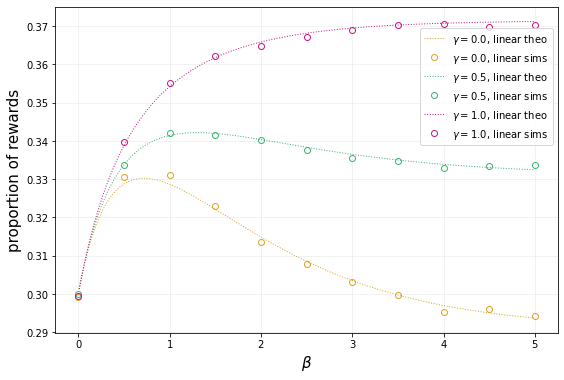

In [459]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=1,
            label='$\gamma={:0.1f}$, linear theo'.format(gammas[i]), 
            linestyle='dotted', linewidth=1)
    ax.plot(simBetas, sim_LINEAR_30[i], color=colors[i], marker='o', fillstyle='none', linestyle='none',
            label='$\gamma={:0.1f}$, linear sims'.format(gammas[i]))

ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# now add sqrt

In [431]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g        = sp.symbols('a b x g')

In [432]:
f0p0high = p1 / (1-sp.exp(-(b**2))) * sp.integrate(sp.exp(-x), (x, b**2, sp.oo))
f0p0high

p_1*exp(-b**2)/(1 - exp(-b**2))

In [433]:
integrand = p1 * sp.exp(-x) * (sp.exp(-(b**2)+x) + a*(1-sp.exp(-(b**2)+x)) + (1-a)*(1-sp.exp(-(b**2)+x))*(a+(1-a)*g)) / (1-sp.exp(-(b**2)))
f0p0low = sp.integrate(integrand, (x,0,b**2))
f0p0low

b**2*(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b**2) - 1) + Piecewise((-(-a**2*g*p_1*exp(b**2) + a**2*p_1*exp(b**2) + 2*a*g*p_1*exp(b**2) - 2*a*p_1*exp(b**2) - g*p_1*exp(b**2))/(exp(b**2) - 1) + (-a**2*g*p_1*exp(b**2) + a**2*p_1*exp(b**2) + 2*a*g*p_1*exp(b**2) - 2*a*p_1*exp(b**2) - g*p_1*exp(b**2))*exp(-b**2)/(exp(b**2) - 1), Ne(b, 0)), (b**2*(-(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b**2) - 1) + (a**2*g*p_1*exp(b**2) - a**2*g*p_1 - a**2*p_1*exp(b**2) + a**2*p_1 - 2*a*g*p_1*exp(b**2) + 2*a*g*p_1 + 2*a*p_1*exp(b**2) - 2*a*p_1 + g*p_1*exp(b**2) - g*p_1 + p_1)/(exp(b**2) - 1)), True))

In [434]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [435]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b**2) - 1) + (2*a - 1)*(b**2*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b**2) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b**2) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b**2) - 1) + (2*a - 1)*(b**2*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b**2))*(3 - a) - b**2*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b**2)))/((2*a - 1)*(exp(b**2) - 1)), True))

In [436]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-(b**2))))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [437]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b**2) - 2*a - exp(b**2) + 1)/(3*a**2*exp(b**2) - 3*a**2 + 2*a - exp(b**2))

In [438]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b**2) - 1) - (2.0*a - 1.0)*(b**2*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b**2) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b**2) - 2.0*a - exp(b**2) + 1.0)/((2.0*a - 1.0)*(exp(b**2) - 1.0)*(3.0*a**2*exp(b**2) - 3.0*a**2 + 2.0*a - exp(b**2))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b**2) - 1) + (2.0*a - 1.0)*(b**2*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b**2) - 1.0) - b**2*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b**2)))*(2.0*a*exp(b**2) - 2.0*a - exp(b**2) + 1.0)/((2.0*a - 1.0)*(exp(b**2) - 1.0)*(3.0*a**2*exp(b**2) - 3.0*a**2 + 2.0*a - exp(b**2))), True))

In [439]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [440]:
alpha  = 0.3
betas  = np.arange(0.01, 5, 0.01)
gammas = [0., 0.5, 1.]

resSqrts = []
for g in gammas:
    resSqrts.append(finalLambda(alpha, betas, g))

In [447]:
# sim in
def simCKWN_beta_lambda_SQRT_EXEC_ONLY(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        time     = np.random.exponential()
        execRews = np.sqrt(time)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [448]:
simBetas = np.arange(0.0, 5.01, 0.5)
gammas   = [0., 1/2, 1.]
scale    = 1.0
a        = 0.3
simBetas

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [452]:
# linear 
sim_SQRT_30 = []
for g in gammas:
    tempOut = []
    for b in tqdm(simBetas):
        temp = []
        for j in range(10):
            res = simCKWN_beta_lambda_SQRT_EXEC_ONLY(alpha=0.3, gamma=g, beta=b, n=int(1e5))
            temp.append(res)
        tempOut.append(np.mean(temp))
    sim_SQRT_30.append(tempOut)
sim_SQRT_30 = np.asarray(sim_SQRT_30)
sim_SQRT_30.shape

100%|██████████| 11/11 [01:21<00:00,  7.37s/it]


(3, 11)

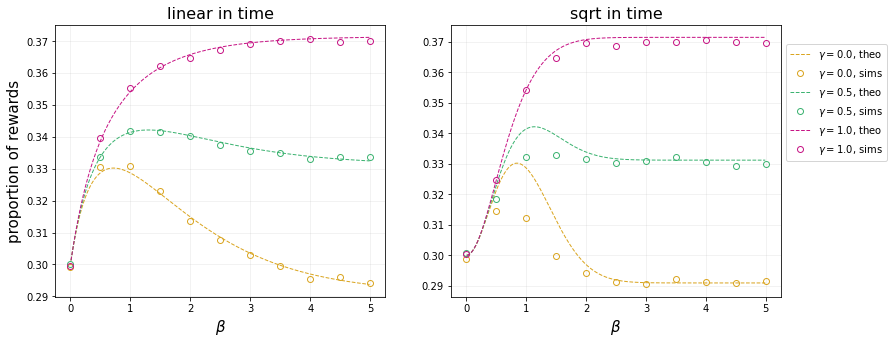

In [463]:
f, axarr = plt.subplots(ncols=2, figsize=(13,5))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    axarr[0].plot(betas, resTheir[i], color=colors[i], alpha=1,
            label='$\gamma={:0.1f}$, theo'.format(gammas[i]), 
            linestyle='dashed', linewidth=1)
    axarr[0].plot(simBetas, sim_LINEAR_30[i], color=colors[i], marker='o', fillstyle='none', linestyle='none',
            label='$\gamma={:0.1f}$, linear sims'.format(gammas[i]))
    
for i in [0, 1, 2]:
    axarr[1].plot(betas, resSqrts[i], color=colors[i], alpha=1,
            label='$\gamma={:0.1f}$, theo'.format(gammas[i]), 
            linestyle='dashed', linewidth=1)
    axarr[1].plot(simBetas, sim_SQRT_30[i], color=colors[i], marker='o', fillstyle='none', linestyle='none',
            label='$\gamma={:0.1f}$, sims'.format(gammas[i]))
    
    

for ax in axarr:
    ax.set_xlabel(r'$\beta$', size=15)
    ax.grid(alpha=0.2)
    
axarr[0].set_ylabel(r'proportion of rewards', size=15)
axarr[1].legend(bbox_to_anchor=(1,.95))
axarr[0].set_title('linear in time', size=16)
axarr[1].set_title('sqrt in time', size=16)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()